In [229]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns= 100
pd.options.display.max_rows= 1000

In [69]:
fleet = pd.read_csv('data/fleet_reg.csv')
portlog = pd.read_excel('data/portlog.xlsx')
vsl_pos = pd.read_csv('data/vsl_pos_170101_170531.csv')
bci = pd.read_csv('data/bci_170101_170531.csv')
all_large_ship_journies = pd.read_csv('data/all_large_ship_journies.csv')

In [199]:
bci_dates = pd.read_csv('data/bci_170101_170531.csv', index_col = 'date')

In [9]:
large_fleet = fleet.loc[fleet['dwt'] > 120000]

In [129]:
large_pos_details = all_large_ship_journies.merge(large_fleet, how='left', on='imo')
large_pos_details = large_pos_details.merge(portlog, how='left', left_on='port', right_on='name')

In [130]:
large_pos_details.columns

Index(['index', 'imo', 'date', 'lat', 'lon', 'speed', 'draft_x', 'eta',
       'destination', 'status_x', 'port', 'fairplay_id', 'mmsi', 'name_x',
       'built', 'cancel_date', 'ship_class', 'build_country', 'dwt',
       'delivery_date', 'est_completion_date', 'group_owner', 'last_update',
       'launch_date', 'newbuilding_px', 'operator', 'order_date',
       'registered_owner', 'sale_date', 'sale_px', 'service_speed',
       'ship_type', 'ship_type_group', 'shipbuilder', 'shipmanager',
       'subcontractor', 'subcontractor_yard_no', 'yard_no', 'year', 'status_y',
       'broken_up', 'min_draft', 'max_draft', 'created_at', 'updated_at',
       'draft_y', 'geared', 'vessel_class', 'name_y', 'latmin', 'latmax',
       'longmin', 'longmax', 'porttype', 'commodity', 'country'],
      dtype='object')

In [131]:
large_pos_details['date'] = pd.to_datetime(large_pos_details['date'])
large_pos_details['date_round'] = large_pos_details['date'].apply(lambda x: x.date())
large_pos_details['date_round'] = large_pos_details['date_round'].astype(str)

large_pos_details['eta'] = pd.to_datetime(large_pos_details['date'])
large_pos_details['eta_date'] = large_pos_details['eta'].apply(lambda x: x.date())
large_pos_details['eta_date'] = large_pos_details['eta_date'].astype(str)

large_pos_details['port'] = large_pos_details['port'].astype(str)

In [132]:
arrivals = large_pos_details.loc[large_pos_details['status_x'] == 'arrived']

In [133]:
dwt_arrivals = arrivals[['date_round', 'dwt']].groupby('date_round', as_index = False).sum()

In [134]:
bci['date'] = pd.to_datetime(bci['date']).astype(str)

In [135]:
feature_set = bci.merge(dwt_arrivals, left_on = 'date', right_on = 'date_round')

In [136]:
feature_set[['value', 'dwt']].cov()

,value,dwt
value,1.457138e+07,1.174747e+09
dwt,1.174747e+09,7.060485e+12


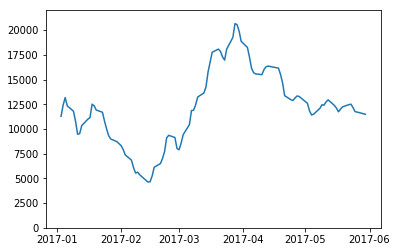

In [159]:
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(feature_set['date']) ,feature_set['value'])
ax.set_ylim(0,22000)
plt.show()

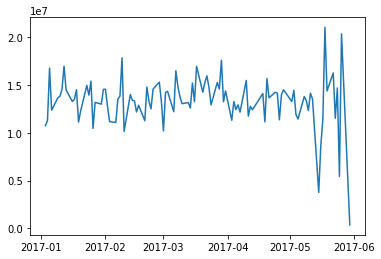

In [190]:
# Check if there is relationship between the amount of cargo arriving and index
# Doesn't look like it
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(feature_set['date']) ,feature_set['dwt'])
plt.show()

In [161]:
in_port = large_pos_details.loc[large_pos_details['port'] != 'nan']

In [173]:
count_in_port = in_port[['date_round', 'index']].groupby('date_round', as_index = False).count()

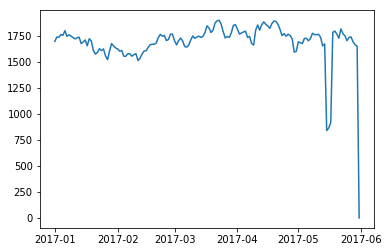

In [183]:
#Check relationship between number of ships in port and index
# Also looks very faint

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(count_in_port['date_round']) ,count_in_port['index'])
plt.show()

In [176]:
what_type_of_ports = arrivals[['date_round', 'commodity', 'index']].pivot_table(index='date_round',columns='commodity',aggfunc=lambda x: x.count())

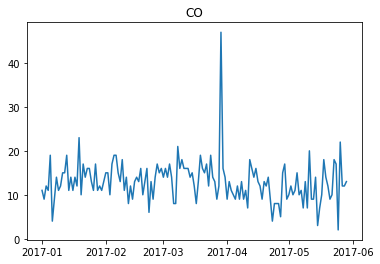

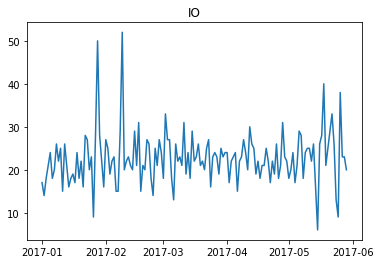

In [189]:
#Any relationships visible between number of ships arriving in dofferent port commodities
#Most ports seem to be NaN so unlikely to be any relationship

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(what_type_of_ports.index) ,what_type_of_ports['index']['CO'])
ax.set_title('CO')
plt.show()
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(what_type_of_ports.index) ,what_type_of_ports['index']['IO'])
ax.set_title('IO')
plt.show()

As no features I'm creating appear to show any promising relationships with the index value I will try some Time Series Forecasting

## Time Series Forecasting

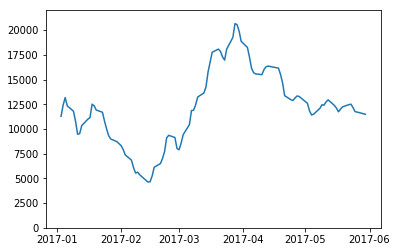

In [193]:
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(feature_set['date']) ,feature_set['value'])
ax.set_ylim(0,22000)
plt.show()

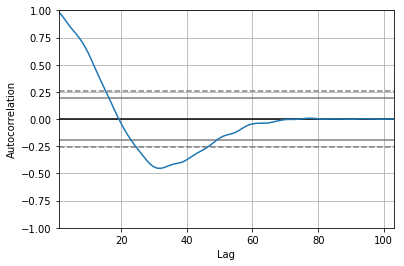

In [204]:
#Maybe significant correlation up to ~15 days out
pd.plotting.autocorrelation_plot(bci_dates['value'])

In [213]:
X=bci_dates['value'].astype(float)

In [217]:
size = int(len(X) * 0.66)

In [218]:
train, test = X[0:size], X[size:len(X)]

In [220]:
history = [x for x in train]

In [228]:
pred = []
for i in range(len(test)):
    model = ARIMA(history,order=(15,1,0))
    modelf = model.fit(disp=0)
    output = modelf.forecast()
    yhat = output[0]
    pred.append(yhat)
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


/home/tom/app/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/tom/app/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/tom/app/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=15649.902398, expected=15698.000000
predicted=15690.089635, expected=15570.000000
predicted=15920.162151, expected=15493.000000
predicted=15480.675789, expected=16000.000000
predicted=15923.582664, expected=16287.000000
predicted=15989.558720, expected=16361.000000
predicted=16378.749505, expected=16154.000000
predicted=16072.436406, expected=15524.000000
predicted=14695.673957, expected=14660.000000
predicted=14107.126359, expected=13369.000000
predicted=12706.525174, expected=12960.000000
predicted=12900.861197, expected=12879.000000
predicted=13115.149934, expected=13135.000000
predicted=13593.848044, expected=13340.000000
predicted=13505.746677, expected=13285.000000
predicted=12930.487310, expected=12598.000000
predicted=11950.666318, expected=11840.000000
predicted=11265.523636, expected=11414.000000
predicted=10974.874760, expected=11499.000000
predicted=11667.653075, expected=12082.000000
predicted=12747.543086, expected=12446.000000
predicted=12679.605743, expected=1

/home/tom/app/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12419.494541, expected=12177.000000
predicted=11990.380999, expected=11750.000000
predicted=11436.229372, expected=11709.000000
predicted=11637.377132, expected=11484.000000
predicted=11360.132693, expected=11053.000000


NameError: name 'mean_squared_error' is not defined

In [230]:
error = mean_squared_error(test, pred)
print('Test MSE: %.3f' % error)

Test MSE: 119248.954


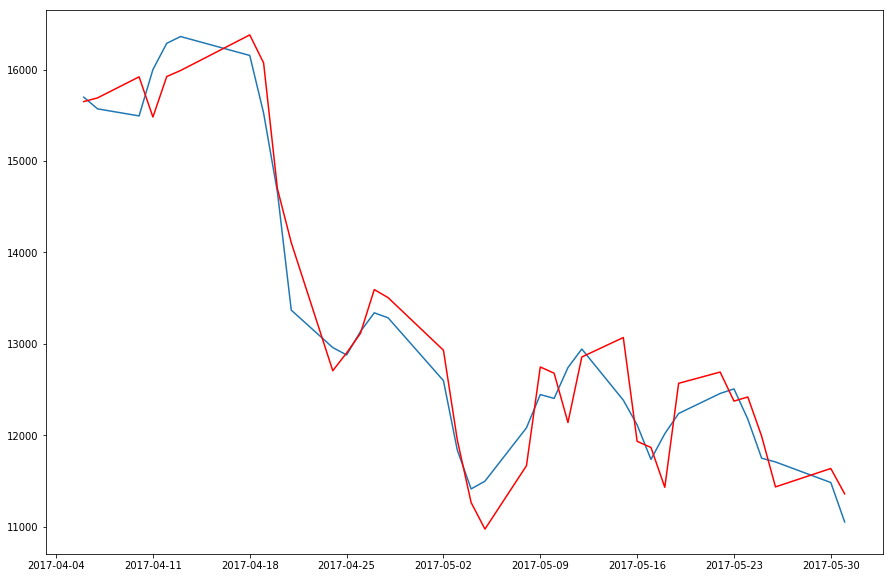

In [244]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.figsize = 1000
ax.plot(pd.to_datetime(test.index), test)
ax.plot(pd.to_datetime(test.index), pred, color='red')
plt.show()